# Read Traffic Data

The NY DOT publishes [real-time traffic data](http://www.nyc.gov/html/dot/html/about/datafeeds.shtml#realtime) through speed detectors at various points in the city.

From the [metadata description](http://a841-dotweb01.nyc.gov/datafeeds/TrafficSpeed/metadata_trafficspeeds.pdf):

1. **Id**: TRANSCOM Link ID
1. **Speed**: Average speed a vehicle traveled between end points on the link in the most recent interval
1. **TravelTime**: Time the average vehicle took to traverse the link
1. **~~Status~~**: Artifact – not useful
1. **DataAsOf**: Last time data was received from link  
1. **linkId**: TRANSCOM Link ID (same as ID field)
1. **linkPoints**: Sequence of Lat/ Long points, describes locations of the sensor links
1. **EncodedPolyLine**: Google compatible polyline from http://code.google.com/apis/maps/documentation/polylineutility.html
1. **EncodedPolyLineLvls**: Google compatible poly levels from http://code.google.com/apis/maps/documentation/polylineutility.html
1. **Owner**: Owner of the Detector
1. **~~Transcom_id~~**: Artifact – not useful
1. **Borough**: NYC borough (Brooklyn, Bronx, Manhattan, Queens, Staten Island)
1. **LinkName**: Description of the link location and end points

Let's open one up.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

test_file = 'data/traffic/1477008302_traffic.csv'

def try_float(x):
    try:
        return float(x)
    except:
        return float('NaN')

def to_coordinates(linkPoints):
    return [tuple([try_float(x) for x in point.split(',')]) for point in linkPoints.split(' ')]

def all_to_coordinates(linkPointsList):
    return [to_coordinates(lp) for lp in linkPointsList]

def load_traffic(fname):
    df = pd.read_csv(test_file, sep='\t', index_col=0)
    df['linkPoints'] = all_to_coordinates(df['linkPoints'])
    df.drop('Status', axis=1, inplace=True)
    df.drop('Transcom_id', axis=1, inplace=True)
    return df[[('2016' in asof) for asof in df['DataAsOf']]]

test_frame = load_traffic(test_file)

In [2]:
has_nans = 0
for lp in test_frame['linkPoints'][:10]:
    strlp = str(lp)
    if 'nan' in strlp:
        has_nans += 1
        print(strlp)
for lp in test_frame['linkPoints'][10:]:
    strlp = str(lp)
    if 'nan' in strlp:
        has_nans += 1
        
print('Has NaN:', has_nans)
    
test_frame[:3]

[(40.77158, -73.994441), (40.7713004, -73.99455), (40.77085, -73.99467), (40.76997, -73.99481), (40.7701604, -73.99477), (40.76986, -73.994831), (40.7695406, -73.99496), (40.769341, -73.99508), (40.768311, -73.9958), (40.768311, -73.9958), (40.76623, -73.99733), (40.76623, -73.99733), (40.76547, -73.9979), (nan,)]
Has NaN: 24


,Speed,TravelTime,DataAsOf,linkId,linkPoints,EncodedPolyLine,EncodedPolyLineLvls,Owner,Borough,linkName
Id,,,,,,,,,,
1,24.23,225,10/20/2016 20:06:15,4616337,"[(40.74047, -74.009251), (40.74137, -74.00893)...",}btwFx|ubMsD_AgJcAcR{ByJ_AsBFiEbByCXaFuAkLiDsT...,BBBBBBBBBBBBB,NYC_DOT_LIC,Manhattan,11th ave n ganservoort - 12th ave @ 40th st
2,24.23,135,10/20/2016 20:06:15,4616325,"[(40.73933, -74.01004), (40.73895, -74.01012),...",y{swFvavbMjANlGSvQn@fa@fBhQdA,BBBBBB,NYC_DOT_LIC,Manhattan,11th ave s ganservoort - west st @ spring st
3,16.16,381,10/20/2016 20:06:15,4616324,"[(40.76375, -73.999191), (40.763521, -73.99935...",mtxwF|}sbMl@^~GpK|LrIbLlH??lK~G|FtD`C~@}@WdWnG...,BBBBBBBBBBBBBBB,NYC_DOT_LIC,Manhattan,12th ave @ 45th - 11 ave ganservoort st


## Getting Clean Values

Each row of the table is a collection of traffic detectors along a route. Each route has an average speed. Each route is defined by the list of "link points". Each link point is a (latitude, longitude) pair.

Link points are stored in 2 columns: 'linkPoints' (string representation) and 'EncodedPolyLine' which can be decoded by the [polyline](https://pypi.python.org/pypi/polyline/) package.

As we've seen above the link points list has errors on 29 routes. Let's try using the encoded poly lines:

In [3]:
import polyline

def decpol(pl):
    try:
        return polyline.decode(pl)
    except:
        print('Error:', pl)
        return float('NaN')
test_frame['PolyLine'] = [decpol(pl) for pl in test_frame['EncodedPolyLine']]
test_frame[:2]

Error: _pfxF`}yaMdFsWfDmPpH}^lEgTBBBBB
Error: cl}wFtbkaMfFiIdByBrD{DtAeAj@_@nA}@|BcAvBy@hBc@zDm@jBOrBY|C_@f@EpHk@|Is@????bIOrGa@xHcBvFyBtImDzHgDtBcAtCoApCgAbEqA~QuHxGqDbCUbCRjEcApEy@jGeAtEi@dBg@t@SdRyGzHwC|IcDbKuDdLeEnM}ExOwFzRsHnCoArGeEtOaQjGqMbCoJ|@{GDuIe@Sf


,Speed,TravelTime,DataAsOf,linkId,linkPoints,EncodedPolyLine,EncodedPolyLineLvls,Owner,Borough,linkName,PolyLine
Id,,,,,,,,,,,
1,24.23,225,10/20/2016 20:06:15,4616337,"[(40.74047, -74.009251), (40.74137, -74.00893)...",}btwFx|ubMsD_AgJcAcR{ByJ_AsBFiEbByCXaFuAkLiDsT...,BBBBBBBBBBBBB,NYC_DOT_LIC,Manhattan,11th ave n ganservoort - 12th ave @ 40th st,"[(40.74047, -74.00925), (40.74137, -74.00893),..."
2,24.23,135,10/20/2016 20:06:15,4616325,"[(40.73933, -74.01004), (40.73895, -74.01012),...",y{swFvavbMjANlGSvQn@fa@fBhQdA,BBBBBB,NYC_DOT_LIC,Manhattan,11th ave s ganservoort - west st @ spring st,"[(40.73933, -74.01004), (40.73895, -74.01012),..."


Better, but some strings need correcting. The online polyline tool can detect minor errors and decode them.

In [4]:
test_frame['EncodedPolyLine'] = test_frame['EncodedPolyLine'].replace(
    '_pfxF`}yaMdFsWfDmPpH}^lEgTBBBBB', '_pfxF`}yaMdFsWfDmPpH}^lEgTBBBBB@')

test_frame['EncodedPolyLine'] = test_frame['EncodedPolyLine'].replace(
    'cl}wFtbkaMfFiIdByBrD{DtAeAj@_@nA}@|BcAvBy@hBc@zDm@jBOrBY|C_@f@EpHk@|Is@????bIOrGa@xHcBvFyBtImDzHgDtBcAtCoApCgAbEqA~QuHxGqDbCUbCRjEcApEy@jGeAtEi@dBg@t@SdRyGzHwC|IcDbKuDdLeEnM}ExOwFzRsHnCoArGeEtOaQjGqMbCoJ|@{GDuIe@Sf',
    'cl}wFtbkaMfFiIdByBrD{DtAeAj@_@nA}@|BcAvBy@hBc@zDm@jBOrBY|C_@f@EpHk@|Is@????bIOrGa@xHcBvFyBtImDzHgDtBcAtCoApCgAbEqA~QuHxGqDbCUbCRjEcApEy@jGeAtEi@dBg@t@SdRyGzHwC|IcDbKuDdLeEnM}ExOwFzRsHnCoArGeEtOaQjGqMbCoJ|@{GDuIe@Sf@@')

test_frame['PolyLine'] = np.array([polyline.decode(pl) for pl in test_frame['EncodedPolyLine']])
test_frame[:2]

,Speed,TravelTime,DataAsOf,linkId,linkPoints,EncodedPolyLine,EncodedPolyLineLvls,Owner,Borough,linkName,PolyLine
Id,,,,,,,,,,,
1,24.23,225,10/20/2016 20:06:15,4616337,"[(40.74047, -74.009251), (40.74137, -74.00893)...",}btwFx|ubMsD_AgJcAcR{ByJ_AsBFiEbByCXaFuAkLiDsT...,BBBBBBBBBBBBB,NYC_DOT_LIC,Manhattan,11th ave n ganservoort - 12th ave @ 40th st,"[(40.74047, -74.00925), (40.74137, -74.00893),..."
2,24.23,135,10/20/2016 20:06:15,4616325,"[(40.73933, -74.01004), (40.73895, -74.01012),...",y{swFvavbMjANlGSvQn@fa@fBhQdA,BBBBBB,NYC_DOT_LIC,Manhattan,11th ave s ganservoort - west st @ spring st,"[(40.73933, -74.01004), (40.73895, -74.01012),..."


In [5]:
# The complete traffic reader

def load_traffic_2(fname):
    df = None
    try:
        df = pd.read_csv('data/traffic/' + fname, sep='\t', index_col=0)
    except:
        print(fname)
        raise ValueError()
    #df['linkPoints'] = all_to_coordinates(df['linkPoints'])
    df.drop('Status', axis=1, inplace=True)
    df.drop('Transcom_id', axis=1, inplace=True)
    df = df[[('2016' in asof) for asof in df['DataAsOf']]]
    df['DataAsOf'] = pd.to_datetime(df['DataAsOf'], infer_datetime_format=True)
    
    # Correct some broken polylines
    df['EncodedPolyLine'] = df['EncodedPolyLine'].replace(
    '_pfxF`}yaMdFsWfDmPpH}^lEgTBBBBB', '_pfxF`}yaMdFsWfDmPpH}^lEgTBBBBB@')
    df['EncodedPolyLine'] = df['EncodedPolyLine'].replace(
        'cl}wFtbkaMfFiIdByBrD{DtAeAj@_@nA}@|BcAvBy@hBc@zDm@jBOrBY|C_@f@EpHk@|Is@????bIOrGa@xHcBvFyBtImDzHgDtBcAtCoApCgAbEqA~QuHxGqDbCUbCRjEcApEy@jGeAtEi@dBg@t@SdRyGzHwC|IcDbKuDdLeEnM}ExOwFzRsHnCoArGeEtOaQjGqMbCoJ|@{GDuIe@Sf',
        'cl}wFtbkaMfFiIdByBrD{DtAeAj@_@nA}@|BcAvBy@hBc@zDm@jBOrBY|C_@f@EpHk@|Is@????bIOrGa@xHcBvFyBtImDzHgDtBcAtCoApCgAbEqA~QuHxGqDbCUbCRjEcApEy@jGeAtEi@dBg@t@SdRyGzHwC|IcDbKuDdLeEnM}ExOwFzRsHnCoArGeEtOaQjGqMbCoJ|@{GDuIe@Sf@@')

    df['PolyLine'] = [polyline.decode(pl) for pl in df['EncodedPolyLine']]
    
    df.drop('linkPoints', axis=1, inplace=True)
    df.drop('EncodedPolyLine', axis=1, inplace=True)
    df.drop('EncodedPolyLineLvls', axis=1, inplace=True)
    
    speed_data = df[['linkId', 'Speed', 'TravelTime', 'DataAsOf']]
    metadata = df[['linkId', 'Owner', 'Borough', 'linkName', 'PolyLine']]
    return (speed_data, metadata)

file2 = '1477307402_traffic.csv'
speed_data_2, metadata_2 = load_traffic_2(file2)

In [6]:
metadata_2[5:8]

,linkId,Owner,Borough,linkName,PolyLine
Id,,,,,
110,4616281,NYC_DOT_LIC,Staten Island,440 N FRANCIS STREET - WSE N TYRELLAN AVE,"[(40.5256, -74.23039), (40.52551, -74.23214), ..."
119,4456502,MTA Bridges & Tunnels,Manhattan,BBT E Manhattan Portal - Toll Plaza,"[(40.70631, -74.01501), (40.70538, -74.01528),..."
124,4456501,MTA Bridges & Tunnels,Manhattan,BBT W Toll Plaza - Manhattan Portal,"[(40.68036, -74.00441), (40.6822, -74.00572), ..."


In [7]:
print(len(metadata_2))

138


## Separating Data and Metadata

There are two types of data in the frame above:
* Frequently changing data (Speed, TravelTime, DataAsOf)
* Metadata (Owner, Borough, LinkName, PolyLine)

The two are linked by the linkId. To save space, let's split the two.

In [8]:
from os import listdir
from os.path import isfile, join

traffic_path = 'data/traffic'
traffic_files = sorted([f for f in listdir(traffic_path) if isfile(join(traffic_path, f))])
traffic_files = list(filter(lambda f: 'swp' not in f, traffic_files))

print('# files:', len(traffic_files))
traffic_files[:10]

# files: 7095


['1476711728_traffic.csv',
 '1476712202_traffic.csv',
 '1476712502_traffic.csv',
 '1476712802_traffic.csv',
 '1476713103_traffic.csv',
 '1476713403_traffic.csv',
 '1476713702_traffic.csv',
 '1476714002_traffic.csv',
 '1476714302_traffic.csv',
 '1476714602_traffic.csv']

In [9]:
# Read the metadata for now.
max_files = 100

# Read 100 files to figure out what the route names are.
all_meta = metadata_2
for fname in traffic_files[:max_files]:
    _, meta = load_traffic_2(fname)
    
    all_meta = pd.concat([all_meta, meta])

In [45]:
print(len(all_meta.drop_duplicates(subset=['linkId'])))
print(len(all_meta.drop_duplicates(subset=['linkName'])))

138
138


In [46]:
metadata_2.to_csv('traffic_routes.csv')

## Joining With Stations

Let's find out the top 3 routes (rows in the metadata table) that are closest to the Citi Bike station. For each closest route we'll get:
* The lat-lng point in the route (traffic_1_point)
* The name of the route (traffic_1_name)
* The link ID of the route (traffic_1_linkId)
* How far is the closest point to the station (traffic_1_distance)

To simplify things, we're going to compare each citibike station against the link points in the dataset. The distance between a station and a route is the minimum distance between the station and one of the link points.

If it turns out more accuracy is needed, we can subdivide the segments between link points to get a better accuracy.

In [10]:
import json

si = None
with open('station_information.json', 'r') as f:
    si = json.loads(f.read())
    
si

{'data': {'stations': [{'capacity': 39,
    'eightd_has_key_dispenser': False,
    'lat': 40.76727216,
    'lon': -73.99392888,
    'name': 'W 52 St & 11 Ave',
    'region_id': 71,
    'rental_methods': ['KEY', 'CREDITCARD'],
    'short_name': '6926.01',
    'station_id': '72'},
   {'capacity': 33,
    'eightd_has_key_dispenser': False,
    'lat': 40.71911552,
    'lon': -74.00666661,
    'name': 'Franklin St & W Broadway',
    'region_id': 71,
    'rental_methods': ['KEY', 'CREDITCARD'],
    'short_name': '5430.08',
    'station_id': '79'},
   {'capacity': 27,
    'eightd_has_key_dispenser': False,
    'lat': 40.71117416,
    'lon': -74.00016545,
    'name': 'St James Pl & Pearl St',
    'region_id': 71,
    'rental_methods': ['KEY', 'CREDITCARD'],
    'short_name': '5167.06',
    'station_id': '82'},
   {'capacity': 62,
    'eightd_has_key_dispenser': False,
    'lat': 40.68382604,
    'lon': -73.97632328,
    'name': 'Atlantic Ave & Fort Greene Pl',
    'region_id': 71,
    'rental_

In [11]:
si_frame = pd.DataFrame(si['data']['stations'])
si_frame[:3]

,capacity,eightd_has_key_dispenser,lat,lon,name,region_id,rental_methods,short_name,station_id
0,39,False,40.767272,-73.993929,W 52 St & 11 Ave,71,"[KEY, CREDITCARD]",6926.01,72
1,33,False,40.719116,-74.006667,Franklin St & W Broadway,71,"[KEY, CREDITCARD]",5430.08,79
2,27,False,40.711174,-74.000165,St James Pl & Pearl St,71,"[KEY, CREDITCARD]",5167.06,82


Let's use the package `geopy` to measure distance.

In [12]:
from geopy.distance import vincenty

station_traffic = []

for station in si_frame.iterrows():
    #print(station['lat'], station['lon'])
    station_id = station[1]['station_id']
    station_latlon = (station[1]['lat'], station[1]['lon'])
    distances = [] # (linkId, name, lat, lng, distance(m))
    for route in metadata_2.iterrows():
        linkpoints = route[1]['PolyLine']
        link_id = route[1]['linkId']
        link_name = route[1]['linkName']
        
        min_latlon = None
        min_distance = 10e10
        for latlon in linkpoints:
            local_distance = vincenty(station_latlon, latlon).meters
            if local_distance < min_distance:
                min_distance = local_distance
                min_latlon = latlon
        distances.append({
            'linkId': link_id,
            'linkName': link_name,
            'lat': min_latlon[0],
            'lon': min_latlon[1],
            'distance': min_distance
        })
    
    distances = sorted(distances, key=lambda d: d['distance'])[:3]
    
    merged = {}
    for i, dist in enumerate(distances):
        for key, val in dist.items():
            merged['traffic_{}_{}'.format(i, key)] = val
    merged['station_id'] = station_id
    station_traffic.append(merged)
    
    print(station[1]['name'], ':', distances[0]['linkName'])
    #break # For testing

W 52 St & 11 Ave : 12th Ave S 57th St - 45th St
Franklin St & W Broadway : West St S Spring St - BBT Manhattan Portal outbound
St James Pl & Pearl St : BQE N Atlantic Ave - BKN Bridge Manhattan Side
Atlantic Ave & Fort Greene Pl : BQE N ATLANTIC AVENUE - LEONARD STREET
W 17 St & 8 Ave : 11th ave n ganservoort - 12th ave @ 40th st
Park Ave & St Edwards St : BQE S LEONARD STREET - ATLANTIC AVENUE
Lexington Ave & Classon Ave : BQE N ATLANTIC AVENUE - LEONARD STREET
Barrow St & Hudson St : 11th ave s ganservoort - west st @ spring st
MacDougal St & Prince St : West St S Spring St - BBT Manhattan Portal outbound
E 56 St & Madison Ave : FDR S 63rd - 25th St
Clinton St & Joralemon St : GOW N 9TH STREET - ATLANTIC AVENUE
Nassau St & Navy St : BQE S LEONARD STREET - ATLANTIC AVENUE
Hudson St & Reade St : West St S Spring St - BBT Manhattan Portal outbound
Greenwich St & Warren St : West St S Spring St - BBT Manhattan Portal outbound
E 2 St & Avenue C : FDR S 25th St - Catherine Slip
Cleveland P

In [13]:
station_traffic_df = pd.DataFrame(station_traffic)
station_traffic_df

,station_id,traffic_0_distance,traffic_0_lat,traffic_0_linkId,traffic_0_linkName,traffic_0_lon,traffic_1_distance,traffic_1_lat,traffic_1_linkId,traffic_1_linkName,traffic_1_lon,traffic_2_distance,traffic_2_lat,traffic_2_linkId,traffic_2_linkName,traffic_2_lon
0,72,195.550598,40.76831,4616323,12th Ave S 57th St - 45th St,-73.99580,236.896703,40.76930,4616338,12th Ave N 40th - 57th St,-73.99480,469.078260,40.77149,4620343,Westside Hwy N 57th St - GWB,-73.99423
1,79,492.702692,40.71955,4456494,West St S Spring St - BBT Manhattan Portal out...,-74.01247,871.428163,40.72619,4616325,11th ave s ganservoort - west st @ spring st,-74.01113,1064.149186,40.71580,4616340,BQE N Atlantic Ave - MAN Bridge Manhattan Side,-73.99485
2,82,178.010050,40.71006,4616339,BQE N Atlantic Ave - BKN Bridge Manhattan Side,-74.00168,317.442797,40.70868,4616342,BKN Bridge Manhattan Side - FDR N Catherine Slip,-73.99833,326.703057,40.70861,4616341,FDR S Catherine Slip - BKN Bridge Manhattan Side,-73.99827
3,83,1407.241860,40.69627,4616257,BQE N ATLANTIC AVENUE - LEONARD STREET,-73.97947,1418.452784,40.69638,4616271,BQE S LEONARD STREET - ATLANTIC AVENUE,-73.97942,1816.702289,40.69882,4616340,BQE N Atlantic Ave - MAN Bridge Manhattan Side,-73.98492
4,116,618.726161,40.74317,4616337,11th ave n ganservoort - 12th ave @ 40th st,-74.00859,655.242789,40.74114,4616324,12th ave @ 45th - 11 ave ganservoort st,-74.00921,770.974009,40.73933,4616325,11th ave s ganservoort - west st @ spring st,-74.01004
5,119,121.496169,40.69638,4616271,BQE S LEONARD STREET - ATLANTIC AVENUE,-73.97942,123.004312,40.69627,4616257,BQE N ATLANTIC AVENUE - LEONARD STREET,-73.97947,642.107317,40.69905,4616340,BQE N Atlantic Ave - MAN Bridge Manhattan Side,-73.98456
6,120,1097.868304,40.69576,4616257,BQE N ATLANTIC AVENUE - LEONARD STREET,-73.96468,1111.814295,40.69609,4616271,BQE S LEONARD STREET - ATLANTIC AVENUE,-73.96408,2534.844428,40.69905,4616340,BQE N Atlantic Ave - MAN Bridge Manhattan Side,-73.98456
7,127,436.093630,40.73460,4616325,11th ave s ganservoort - west st @ spring st,-74.01026,716.225227,40.72620,4456494,West St S Spring St - BBT Manhattan Portal out...,-74.01112,895.108434,40.73939,4616324,12th ave @ 45th - 11 ave ganservoort st,-74.01002
8,128,695.710336,40.72620,4456494,West St S Spring St - BBT Manhattan Portal out...,-74.01112,696.707064,40.72619,4616325,11th ave s ganservoort - west st @ spring st,-74.01113,1430.428008,40.71580,4616340,BQE N Atlantic Ave - MAN Bridge Manhattan Side,-73.99485
9,137,1171.047270,40.75485,4616332,FDR S 63rd - 25th St,-73.96230,1184.439634,40.75490,4616329,FDR N 25th - 63rd St,-73.96204,1668.365714,40.74670,4456510,QMT W Toll Plaza - Manhattan Side,-73.97515


In [14]:
stations_and_traffic = pd.merge(si_frame, station_traffic_df, on='station_id', how='left')
stations_and_traffic[:5]

,capacity,eightd_has_key_dispenser,lat,lon,name,region_id,rental_methods,short_name,station_id,traffic_0_distance,...,traffic_1_distance,traffic_1_lat,traffic_1_linkId,traffic_1_linkName,traffic_1_lon,traffic_2_distance,traffic_2_lat,traffic_2_linkId,traffic_2_linkName,traffic_2_lon
0,39,False,40.767272,-73.993929,W 52 St & 11 Ave,71,"[KEY, CREDITCARD]",6926.01,72,195.550598,...,236.896703,40.76930,4616338,12th Ave N 40th - 57th St,-73.99480,469.078260,40.77149,4620343,Westside Hwy N 57th St - GWB,-73.99423
1,33,False,40.719116,-74.006667,Franklin St & W Broadway,71,"[KEY, CREDITCARD]",5430.08,79,492.702692,...,871.428163,40.72619,4616325,11th ave s ganservoort - west st @ spring st,-74.01113,1064.149186,40.71580,4616340,BQE N Atlantic Ave - MAN Bridge Manhattan Side,-73.99485
2,27,False,40.711174,-74.000165,St James Pl & Pearl St,71,"[KEY, CREDITCARD]",5167.06,82,178.010050,...,317.442797,40.70868,4616342,BKN Bridge Manhattan Side - FDR N Catherine Slip,-73.99833,326.703057,40.70861,4616341,FDR S Catherine Slip - BKN Bridge Manhattan Side,-73.99827
3,62,False,40.683826,-73.976323,Atlantic Ave & Fort Greene Pl,71,"[KEY, CREDITCARD]",4354.07,83,1407.241860,...,1418.452784,40.69638,4616271,BQE S LEONARD STREET - ATLANTIC AVENUE,-73.97942,1816.702289,40.69882,4616340,BQE N Atlantic Ave - MAN Bridge Manhattan Side,-73.98492
4,39,False,40.741776,-74.001497,W 17 St & 8 Ave,71,"[KEY, CREDITCARD]",6148.02,116,618.726161,...,655.242789,40.74114,4616324,12th ave @ 45th - 11 ave ganservoort st,-74.00921,770.974009,40.73933,4616325,11th ave s ganservoort - west st @ spring st,-74.01004


In [15]:
stations_and_traffic.to_csv('stations_and_traffic.csv', index=False)

## Read Speed data and Compile to CSV

In [16]:
files_per_pack = 50

# Read 100 files to figure out what the route names are.
all_live = None
i = 0
for fname in traffic_files:
    i += 1
    #print(fname)
    live, _ = load_traffic_2(fname)
    
    if all_live is None:
        all_live = live
    else:
        all_live = pd.concat([all_live, live])
        
    if i % files_per_pack == 0:
        all_live = all_live.drop_duplicates(subset=['linkId', 'DataAsOf'])
        print('i:', i, 'rows:', len(all_live))
    #print(max(all_live['DataAsOf']))

i: 50 rows: 6194
i: 100 rows: 12304
i: 150 rows: 18435
i: 200 rows: 22710
i: 250 rows: 24699
i: 300 rows: 30581
i: 350 rows: 36731
i: 400 rows: 43006
i: 450 rows: 48613
i: 500 rows: 54171
i: 550 rows: 60038
i: 600 rows: 66213
i: 650 rows: 72356
i: 700 rows: 78524
i: 750 rows: 84581
i: 800 rows: 88786
i: 850 rows: 95053
i: 900 rows: 101218
i: 950 rows: 107448
i: 1000 rows: 112996
i: 1050 rows: 119045
i: 1100 rows: 124996
i: 1150 rows: 131189
i: 1200 rows: 137149
i: 1250 rows: 143472
i: 1300 rows: 148606
i: 1350 rows: 149229
i: 1400 rows: 149229
i: 1450 rows: 154468
i: 1500 rows: 160047
i: 1550 rows: 165869
i: 1600 rows: 172028
i: 1650 rows: 177917
i: 1700 rows: 183525
i: 1750 rows: 188566
i: 1800 rows: 194740
i: 1850 rows: 200975
i: 1900 rows: 206576
i: 1950 rows: 212744
i: 2000 rows: 219036
i: 2050 rows: 225106
i: 2100 rows: 231085
i: 2150 rows: 237417
i: 2200 rows: 243236
i: 2250 rows: 244907
i: 2300 rows: 249838
i: 2350 rows: 255597
i: 2400 rows: 261779
i: 2450 rows: 268052
i: 2500 r

In [18]:
all_drop = all_live.drop_duplicates(subset=['linkId', 'DataAsOf'])
all_drop = all_drop.sort_values(by=['DataAsOf', 'linkId'])

In [19]:
all_drop.to_csv('data/traffic_speeds.csv', index=False)

In [20]:
all_drop[:4]

,linkId,Speed,TravelTime,DataAsOf
Id,,,,
205,4362247,11.81,1294,2016-08-05 13:16:46
206,4362252,11.18,1051,2016-08-05 14:17:16
405,4362314,22.99,278,2016-09-02 13:57:17
376,4616192,45.98,109,2016-09-14 16:58:51


## Join Speed data with Bikes and Weather

In [21]:
stations_and_traffic = pd.read_csv('stations_and_traffic.csv')
stations_and_traffic['traffic_0_distance'].describe()

count     664.000000
mean     1029.463373
std       966.303686
min         9.432139
25%       415.996176
50%       808.479953
75%      1277.288554
max      6202.859697
Name: traffic_0_distance, dtype: float64

In [32]:
bikes_and_weather = pd.read_csv('data/bikes_and_weather_1476723624_1478858697.csv')
print(bikes_and_weather.columns)
print(len(bikes_and_weather))
print(bikes_and_weather.columns[22])
print(bikes_and_weather['precipType'].unique())
bikes_and_weather[:3]

Index(['eightd_has_available_keys', 'is_installed', 'is_renting',
       'is_returning', 'last_reported', 'num_bikes_available',
       'num_bikes_disabled', 'num_docks_available', 'num_docks_disabled',
       'station_id', 'weather_ts', 'apparentTemperature', 'cloudCover',
       'dewPoint', 'humidity', 'icon', 'nearestStormBearing',
       'nearestStormDistance', 'ozone', 'precipIntensity',
       'precipIntensityError', 'precipProbability', 'precipType', 'pressure',
       'summary', 'temperature', 'time', 'visibility', 'windBearing',
       'windSpeed'],
      dtype='object')
1311519
precipType
[nan 'rain']


,eightd_has_available_keys,is_installed,is_renting,is_returning,last_reported,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,station_id,...,precipIntensityError,precipProbability,precipType,pressure,summary,temperature,time,visibility,windBearing,windSpeed
0,False,1,1,1,2016-10-17 13:00:24,12,0,13,0,3377,...,NaN,0.0,NaN,1013.59,Partly Cloudy,77.12,2016-10-17 17:00:01,9.59,201,4.81
1,False,1,1,1,2016-10-17 13:00:45,3,0,24,0,372,...,NaN,0.0,NaN,1013.59,Partly Cloudy,77.12,2016-10-17 17:00:01,9.59,201,4.81
2,False,1,1,1,2016-10-17 13:01:41,0,1,23,0,262,...,NaN,0.0,NaN,1013.59,Partly Cloudy,77.12,2016-10-17 17:00:01,9.59,201,4.81


In [33]:
bikes_and_weather['last_reported'] = pd.to_datetime(bikes_and_weather['last_reported'], infer_datetime_format=True)

In [34]:
speeds_by_link_id = {}
for linkId in all_drop['linkId'].unique():
    speeds_by_link_id[linkId] = all_drop[all_drop['linkId'] == linkId]
    
print(speeds_by_link_id.keys())

dict_keys([4616192, 4329472, 4456450, 4763651, 4362244, 4616197, 4616198, 4329473, 4763656, 4362249, 4362250, 4329483, 4362252, 4763650, 4616206, 4616208, 4616209, 4616210, 4616195, 4616212, 4616213, 4620310, 4616215, 4616216, 4616217, 4620314, 4620315, 4456476, 4456477, 4456478, 4456479, 4616325, 4456481, 4616226, 4456483, 4329508, 4616229, 4616241, 4616232, 4620330, 4620331, 4620332, 4456494, 4616239, 4456496, 4456497, 4456498, 4456500, 4456501, 4456502, 4616201, 4456505, 4456506, 4616252, 4616202, 4456510, 4456511, 4616257, 4362251, 4456516, 4616246, 4616204, 4362314, 4620343, 4616205, 4616272, 4616250, 4616276, 4616199, 4616281, 4616282, 4362247, 4763649, 4616259, 4362342, 4616337, 4616297, 4616298, 4616299, 4616300, 4616253, 4616305, 4616211, 4616309, 4616200, 4616312, 4616340, 4616255, 4456452, 4616319, 4616320, 4616323, 4616324, 4616214, 4763648, 4616328, 4616329, 4616332, 4616333, 4616235, 4616338, 4616196, 4763657, 4616341, 4616342, 4616260, 4616346, 4620298, 4616218, 4616350,

In [35]:
stations_and_traffic[:3]

,capacity,eightd_has_key_dispenser,lat,lon,name,region_id,rental_methods,short_name,station_id,traffic_0_distance,...,traffic_1_distance,traffic_1_lat,traffic_1_linkId,traffic_1_linkName,traffic_1_lon,traffic_2_distance,traffic_2_lat,traffic_2_linkId,traffic_2_linkName,traffic_2_lon
0,39,False,40.767272,-73.993929,W 52 St & 11 Ave,71,"['KEY', 'CREDITCARD']",6926.01,72,195.550598,...,236.896703,40.76930,4616338,12th Ave N 40th - 57th St,-73.99480,469.078260,40.77149,4620343,Westside Hwy N 57th St - GWB,-73.99423
1,33,False,40.719116,-74.006667,Franklin St & W Broadway,71,"['KEY', 'CREDITCARD']",5430.08,79,492.702692,...,871.428163,40.72619,4616325,11th ave s ganservoort - west st @ spring st,-74.01113,1064.149186,40.71580,4616340,BQE N Atlantic Ave - MAN Bridge Manhattan Side,-73.99485
2,27,False,40.711174,-74.000165,St James Pl & Pearl St,71,"['KEY', 'CREDITCARD']",5167.06,82,178.010050,...,317.442797,40.70868,4616342,BKN Bridge Manhattan Side - FDR N Catherine Slip,-73.99833,326.703057,40.70861,4616341,FDR S Catherine Slip - BKN Bridge Manhattan Side,-73.99827


In [37]:
bikes_traffic = []

i = 0
for bike_i, bike_record in bikes_and_weather.iterrows():
    i += 1
    if i % 1000 == 0:
        print(i, 'of', len(bikes_and_weather))
    station_id = bike_record['station_id']
    timestamp = bike_record['last_reported']
    station_records = stations_and_traffic[stations_and_traffic['station_id'] == station_id]
    station_records_list = station_records.head(1).to_dict('records')
    
    record = {}
    max_diff = 0
    if len(station_records_list) == 0:
        bikes_traffic.append(record)
        continue

    station_record = station_records_list[0]
    for idx in range(3):
        link_id = station_record['traffic_{}_linkId'.format(idx)]
        speeds = speeds_by_link_id[link_id]
        speed_records = speeds[speeds['DataAsOf'] <= timestamp].tail(1).to_dict('records')
        if len(speed_records) == 0:
            continue
        speed_record = speed_records[0]
        
        record['traffic_{}_linkId'.format(idx)] = link_id
        record['traffic_{}_asof'.format(idx)] = speed_record['DataAsOf']
        record['traffic_{}_speed'.format(idx)] = speed_record['Speed']
        record['traffic_{}_travel_time'.format(idx)] = speed_record['TravelTime']
        record['traffic_{}_distance'.format(idx)] = station_record['traffic_{}_distance'.format(idx)]
    
    bikes_traffic.append(record)

1000 of 1311519
2000 of 1311519
3000 of 1311519
4000 of 1311519
5000 of 1311519
6000 of 1311519
7000 of 1311519
8000 of 1311519
9000 of 1311519
10000 of 1311519
11000 of 1311519
12000 of 1311519
13000 of 1311519
14000 of 1311519
15000 of 1311519
16000 of 1311519
17000 of 1311519
18000 of 1311519
19000 of 1311519
20000 of 1311519
21000 of 1311519
22000 of 1311519
23000 of 1311519
24000 of 1311519
25000 of 1311519
26000 of 1311519
27000 of 1311519
28000 of 1311519
29000 of 1311519
30000 of 1311519
31000 of 1311519
32000 of 1311519
33000 of 1311519
34000 of 1311519
35000 of 1311519
36000 of 1311519
37000 of 1311519
38000 of 1311519
39000 of 1311519
40000 of 1311519
41000 of 1311519
42000 of 1311519
43000 of 1311519
44000 of 1311519
45000 of 1311519
46000 of 1311519
47000 of 1311519
48000 of 1311519
49000 of 1311519
50000 of 1311519
51000 of 1311519
52000 of 1311519
53000 of 1311519
54000 of 1311519
55000 of 1311519
56000 of 1311519
57000 of 1311519
58000 of 1311519
59000 of 1311519
60000 

In [38]:
bikes_traffic_frame = pd.DataFrame(bikes_traffic)

In [39]:
bikes_traffic_frame[333:343]

,traffic_0_asof,traffic_0_distance,traffic_0_linkId,traffic_0_speed,traffic_0_travel_time,traffic_1_asof,traffic_1_distance,traffic_1_linkId,traffic_1_speed,traffic_1_travel_time,traffic_2_asof,traffic_2_distance,traffic_2_linkId,traffic_2_speed,traffic_2_travel_time
333,2016-10-17 13:37:11,92.117198,4616333.0,49.71,203.0,2016-10-17 13:37:11,110.368368,4616328.0,47.85,213.0,2016-10-17 13:37:11,1561.925558,4616340.0,3.11,2500.0
334,2016-10-17 13:37:11,603.086250,4616332.0,45.98,148.0,2016-10-17 13:37:11,646.039322,4616329.0,34.18,201.0,2016-10-17 13:36:22,679.093263,4456510.0,26.10,155.0
335,2016-10-17 13:37:11,202.722524,4616338.0,14.29,234.0,2016-10-17 13:37:09,202.747320,4616323.0,14.91,151.0,2016-10-17 13:37:11,215.658034,4616324.0,16.78,369.0
336,2016-10-17 13:36:22,2426.482855,4456494.0,16.16,329.0,2016-10-17 13:36:22,2545.688444,4456502.0,26.10,243.0,2016-10-17 13:36:22,2580.686455,4456501.0,34.80,184.0
337,2016-10-17 13:36:25,682.284597,4620343.0,50.95,390.0,2016-10-17 13:37:11,696.422859,4616346.0,47.85,410.0,2016-10-17 13:37:11,1045.008499,4616338.0,14.29,234.0
338,2016-10-17 13:37:11,162.091117,4616325.0,21.75,147.0,2016-10-17 13:36:22,168.790465,4456494.0,16.16,329.0,2016-10-17 13:37:11,1301.067396,4616324.0,16.78,369.0
339,2016-10-17 13:37:09,1419.418275,4616257.0,14.91,1474.0,2016-10-17 13:37:09,1433.767074,4616271.0,44.12,323.0,2016-10-17 13:37:09,2597.039274,4616235.0,14.29,706.0
340,2016-10-17 13:36:22,3143.323553,4456494.0,16.16,329.0,2016-10-17 13:37:11,3182.140681,4616325.0,21.75,147.0,2016-10-17 13:36:22,3574.404002,4456502.0,26.10,243.0
341,2016-10-17 13:37:11,349.512099,4616332.0,45.98,148.0,2016-10-17 13:37:11,365.949440,4616329.0,34.18,201.0,2016-10-17 13:36:22,467.608635,4456510.0,26.10,155.0
342,2016-10-17 13:37:09,147.295067,4616229.0,44.12,92.0,2016-10-17 13:37:09,161.205481,4616223.0,41.01,98.0,2016-10-17 13:36:22,420.210592,4456501.0,34.80,184.0


In [40]:
bikes_all_data = pd.concat([bikes_and_weather, bikes_traffic_frame], axis=1)

In [41]:
print(len(bikes_all_data))
bikes_all_data[10000:10010]

1311519


,eightd_has_available_keys,is_installed,is_renting,is_returning,last_reported,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,station_id,...,traffic_1_asof,traffic_1_distance,traffic_1_linkId,traffic_1_speed,traffic_1_travel_time,traffic_2_asof,traffic_2_distance,traffic_2_linkId,traffic_2_speed,traffic_2_travel_time
10000,True,1,1,1,2016-10-17 17:06:39,0,0,45,0,3226,...,2016-10-17 17:06:11,1106.211461,4616346.0,41.01,474.0,2016-10-17 17:06:11,2296.156547,4616338.0,22.99,140.0
10001,True,1,1,1,2016-10-17 17:06:41,3,0,28,0,3354,...,2016-10-17 17:06:11,1912.447286,4616319.0,29.83,414.0,2016-10-17 17:02:11,2444.878131,4616223.0,18.02,225.0
10002,False,1,1,1,2016-10-17 17:06:43,27,2,2,0,303,...,2016-10-17 17:06:22,1012.339302,4456494.0,16.78,302.0,2016-10-17 17:06:11,1023.253852,4616325.0,24.23,136.0
10003,False,1,1,1,2016-10-17 17:06:44,1,0,29,0,174,...,2016-10-17 17:06:11,258.458675,4616333.0,34.80,288.0,2016-10-17 17:06:11,269.859747,4616328.0,45.98,223.0
10004,False,1,1,1,2016-10-17 17:06:44,32,0,5,0,225,...,2016-10-17 17:06:11,134.349217,4616324.0,8.70,675.0,2016-10-17 17:06:11,336.985320,4616325.0,24.23,136.0
10005,False,1,1,1,2016-10-17 17:06:44,5,1,25,0,238,...,2016-10-17 17:06:11,374.563210,4616324.0,8.70,675.0,2016-10-17 17:06:11,477.788051,4616337.0,19.26,274.0
10006,False,1,1,1,2016-10-17 17:06:44,46,2,14,0,83,...,2016-10-17 17:02:11,1418.452784,4616271.0,13.05,1266.0,2016-10-17 17:06:11,1816.702289,4616340.0,19.88,466.0
10007,False,1,1,1,2016-10-17 17:06:48,44,0,3,0,427,...,2016-10-17 17:06:22,166.244964,4456494.0,16.78,302.0,2016-10-17 17:06:22,168.084992,4456502.0,31.69,203.0
10008,False,1,1,1,2016-10-17 17:06:49,14,2,24,0,405,...,2016-10-17 17:06:11,160.741669,4616324.0,8.70,675.0,2016-10-17 17:06:11,162.260632,4616325.0,24.23,136.0
10009,False,1,1,1,2016-10-17 17:06:53,2,1,32,0,3170,...,2016-10-17 17:06:11,911.852999,4616346.0,41.01,474.0,2016-10-17 17:06:11,2344.615866,4616338.0,22.99,140.0


In [42]:
bikes_all_data.to_csv('bikes_all_data.csv', index=False)

In [43]:
stations_and_traffic[stations_and_traffic['station_id'] == 405].to_dict('records')

[{'capacity': 40,
  'eightd_has_key_dispenser': False,
  'lat': 40.739323,
  'lon': -74.008119,
  'name': 'Washington St & Gansevoort St',
  'region_id': 71,
  'rental_methods': "['KEY', 'CREDITCARD']",
  'short_name': '6039.06',
  'station_id': 405,
  'traffic_0_distance': 159.2164471781081,
  'traffic_0_lat': 40.74047,
  'traffic_0_linkId': 4616337,
  'traffic_0_linkName': '11th ave n ganservoort - 12th ave @ 40th st',
  'traffic_0_lon': -74.00925,
  'traffic_1_distance': 160.74166943885461,
  'traffic_1_lat': 40.73939,
  'traffic_1_linkId': 4616324,
  'traffic_1_linkName': '12th ave @ 45th - 11 ave ganservoort st',
  'traffic_1_lon': -74.01002,
  'traffic_2_distance': 162.26063236628138,
  'traffic_2_lat': 40.739329999999995,
  'traffic_2_linkId': 4616325,
  'traffic_2_linkName': '11th ave s ganservoort - west st @ spring st',
  'traffic_2_lon': -74.01004}]

In [45]:
speeds = bikes_all_data[bikes_all_data['station_id'] == 405][['last_reported', 'traffic_0_speed']]
speeds[:10]

MemoryError: 

KeyError: 'last_reported'

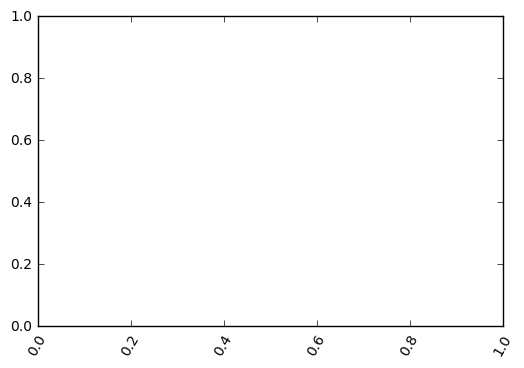

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xticks(rotation=60)
plt.plot(speeds['last_reported'], speeds['traffic_0_speed'])